# Vaccine sentiment classification using Feed-Forward Neural Network
Pavlos Spanoudakis (sdi1800184)

### Select one of the models presented in the report:

In [1]:
MODEL_1 = 1
MODEL_2 = 2
MODEL_3 = 3

MODEL = MODEL_1

### Setting up Data set & Word Embeddings paths

In [2]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"

if MODEL is MODEL_1:
    EMBEDDINGS_PATH = '/mnt/c/Users/pavlo/Downloads/glove.6B.200d.txt'
elif MODEL is MODEL_2:
    EMBEDDINGS_PATH = '/mnt/c/Users/pavlo/Downloads/glove.6B.300d.txt'
elif MODEL is MODEL_3:
    EMBEDDINGS_PATH = '/mnt/c/Users/pavlo/Downloads/glove.6B.50d.txt'

### Setting up NN hyperparameters

In [3]:
if MODEL is MODEL_1:
    LEARNING_RATE = 0.0045
    BATCH_SIZE = 64
    EPOCHS = 175

    LAYER_SIZES = [128, 32, 8]
    USE_RELU = True
    USE_DROPOUT = False
elif MODEL is MODEL_2:
    LEARNING_RATE = 0.0001
    BATCH_SIZE = 128
    EPOCHS = 30

    LAYER_SIZES = [256, 64, 16]
    USE_RELU = True
    USE_DROPOUT = False
elif MODEL is MODEL_3:
    LEARNING_RATE = 0.004
    BATCH_SIZE = 32
    EPOCHS = 100

    LAYER_SIZES = [64, 32, 16, 8]
    USE_RELU = False
    USE_DROPOUT = False

### Setting-up Class-Related information

In [4]:
NUM_CLASSES = 3
CLASS_NAMES = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']

### Necessary Imports

In [5]:
from typing import Callable, Iterable, List, Dict
from numbers import Number

import random
import re

from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import f1_score, recall_score, precision_score, \
                            roc_curve, auc, ConfusionMatrixDisplay

### Setting custom seeds in pseudo-random generators for reproducability

In [6]:
SEED = 32
random.seed(SEED)
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

### Reading data sets & checking whether all samples are valid

In [7]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [8]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

### Trimming the created data frames and extracting only the required data

In [9]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = np.array([ar[0] for ar in features.values])
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = np.array([ar[0] for ar in features.values])
validLabels = validDF['label'].values

### Creating word vectors from the given embeddings file

In [10]:
def createWordVectors(embeddingsPath: str):
    wordVectors: Dict[str, np.ndarray] = {}
    lineElements: List[str] = []
    with open(embeddingsPath) as file:
        # Read file line by line
        for line in file:
            # Remove new line and split
            lineElements = line.replace('\n', '').split()
            # The first element in the line is the target word
            word = lineElements.pop(0)
            # The other elements represent the vector of the word
            wordVector = np.array([float(w) for w in lineElements])
            # Store the vector for this word
            wordVectors[word] = wordVector
    dimensions = len(lineElements)

    return wordVectors, dimensions

### Optional Preprocessor to be used during data vectorization
- Converts the given `str` to lowercase
- Ignores `@` mentions
- Ignores URL's starting with `http://` or `https://`
- Ignores any digits

In [11]:
def customPreprocessor(text: str):    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+|#', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

### Vectorizing Data set Samples
- Each sentence is tokenized using `nltk.TweetVectorizer` into tokens/words.
- We sum up the vectors of each word from the pre-trained embeddings and assign the mean vector to the current sample.

In [12]:
# nltk.TweetTokenizer is used for tweet tokenization
tokenizer = TweetTokenizer()
def vectorizeTweet(tweet: str, preprocessor: Callable[[str], str], wordVectors: Dict[str, np.ndarray], dimensions: int) -> np.ndarray:
    # Split the tweet into words/tokens
    words = tokenizer.tokenize(preprocessor(tweet))
    # words = tokenizer.tokenize(tweet)

    # The sum of the vectors of the tweet words is stored here
    vector: np.ndarray = np.zeros(dimensions)
    for word in words:
        # Get the word/token pre-trained vector
        wordVector = wordVectors.get(word)
        if wordVector is not None:
            # If found, add to the tweet vector
            vector += wordVector
    
    # return the mean vector
    return vector / len(words)

def vectorizeDataSet(dataSet: Iterable[str], dimensions: int, wordVectors: Dict[str, np.ndarray]):
    matrix: np.ndarray = np.zeros(shape=(len(dataSet), dimensions))
    for i, sample in enumerate(dataSet):
        matrix[i] = vectorizeTweet(sample, customPreprocessor, wordVectors, dimensions)
    
    return matrix

### Creating the Neural Network
We create a network with an Input layer, an Output layer and a number of hidden layers (`len(hidden_sizes) - 1`).\
e.g. if `hidden_sizes = [16, 8, 4]` then the neural network will look like this:
- Input Layer (in -> `n_features`, out -> 16)
- Hidden Layer 1 (in -> 16, out -> 8)
- Hidden Layer 2 (in -> 8, out -> 4)
- Output Layer (in -> 4, out -> `n_classes`)


In [13]:
class Network(nn.Module):
    def __init__(self, n_features: int, hidden_sizes: Iterable[int], n_classes: int) -> None:
        super(Network, self).__init__()
        
        if len(hidden_sizes) > 0:
            next_in = hidden_sizes[0]
        else:
            next_in = n_features
        self.layerIn = nn.Linear(n_features, next_in)
        self.hiddenLayers = nn.ModuleList()        
        for size in hidden_sizes[1:]:
            self.hiddenLayers.append(nn.Linear(next_in, size))
            next_in = size
        self.layerOut = nn.Linear(next_in, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    
    def forward(self, input):
        last_out = self.layerIn(input)
        for layer in self.hiddenLayers:
            last_out = layer(last_out)
            if USE_RELU:
                last_out = self.relu(last_out)
            if USE_DROPOUT:
                last_out = self.dropout(last_out)
        
        return self.layerOut(last_out)

### Converting the NN output to predictions
We apply `log_softmax` to the output vector and map each vector to the index of the maximum element of the vector.

In [14]:
def getPredictedLabels(predictions: torch.Tensor) -> np.ndarray:
    softmaxLayerOut = torch.log_softmax(predictions, dim = 1)
    _, labels = torch.max(softmaxLayerOut, dim = 1)
    return labels.detach().numpy()

### Calculating macro accuracy

In [15]:
def calculateAccuracy(predictedLabels: Iterable[Number], trueLabels: Iterable[Number]) -> float:    
    correct = 0
    for pred, true in zip(predictedLabels, trueLabels):
        correct += int(pred == true)
    
    return correct/len(trueLabels)*100

### Plotting a confusion matrix
We can change the displayed labels (`0` -> `Neutral`, `1` -> `Anti-Vaccine`, `2` -> `Pro-Vaccine`) if desired.

In [16]:
def plotConfusionMatrix(trueLabels: Iterable[int], predictions:Iterable[int], title: str, displayLabels: Iterable[str]=None, axes: plt.Axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions, cmap=plt.cm.Reds, ax=axes, colorbar=False)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    axes.set_xlabel('Classifier predicted labels', fontsize=11)
    axes.set_ylabel('True labels', fontsize=11)
    axes.set_title(title, fontsize=14)

### Plotting F1 learning curves
We calculate the F1 score on the Train and Validation sets after every epoch, to create the corresponding F1 learning curves.

In [17]:
def displayF1Curves(epochs: int, tScores: Iterable[Number], vScores: Iterable[Number]):

    epochValues = [i for i in range(epochs)]

    _, axes = plt.subplots(1, 1, figsize=(7, 6))
    axes.grid()
    axes.set_title('F1 Scores')
    axes.plot(epochValues, tScores, "-", color="r", label="Training Set score")
    axes.plot(epochValues, vScores, "-", color="g", label="Validation Set score")

    yValues = np.concatenate((tScores, vScores))
    axes.set_xlim((epochValues[0], epochValues[-1]))
    axes.set_ylim(( round(min(yValues) - 0.05, 1), round(max(yValues) + 0.05, 1) ))
    axes.legend(loc="best")

    plt.show()

### Calculating metric scores on the trained model predictions
- For each different training set size, we calculate the **F1**, **Precision** and **Recall** scores
of the predictions made by the classifier after the end of the train phase, on the training & validation sets.
- We store these scores in two `dict` objects which we return.

In [18]:
F1_KEY = "F1"
PREC_KEY = "Precision"
REC_KEY = "Recall"

def metricScores(trainPredictions: Iterable[int], validPredictions: Iterable[int], trainLabels: Iterable[int], validLabels: Iterable[int]):
    tScores = {}
    vScores = {}
    tScores[F1_KEY] = round(f1_score(trainLabels, trainPredictions, average="micro"), 4)
    tScores[PREC_KEY] = round(precision_score(trainLabels, trainPredictions, average="macro"), 4)
    tScores[REC_KEY] = round(recall_score(trainLabels, trainPredictions, average="macro"), 4)

    vScores[F1_KEY] = round(f1_score(validLabels, validPredictions, average="micro"), 4)
    vScores[PREC_KEY] = round(precision_score(validLabels, validPredictions, average="macro"), 4)
    vScores[REC_KEY] = round(recall_score(validLabels, validPredictions, average="macro"), 4)
    
    return tScores, vScores

### Getting the final scores in a data frame
We place the scores of the predictions made after training with 100% of
the training set in a data frame for better readability.

In [19]:
def metricStatsDF(tScores: Dict[str, Number], vScores: Dict[str, Number]):
    metricStats: Dict[str, List[Number]] = {}
    for metric in tScores:
        metricStats[metric] = [tScores[metric], vScores[metric]]
    
    return pd.DataFrame(metricStats, index=['Train', 'Validation'])

### Plotting Loss curves for the after-training predictions on the Training & Validation sets

In [20]:
def plotLossCurves(trainLosses: Iterable[Number], validationLosses: Iterable[Number], axes: plt.Axes = None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    
    axes.grid()
    axes.set_title("Loss Curves", fontsize=14)
    axes.set_xlabel('Epochs', fontsize=12)
    axes.set_ylabel('Loss', fontsize=12)
    
    epochs = [i for i in range(len(validationLosses))]

    axes.plot(epochs, trainLosses, label='Train Set')
    axes.plot(epochs, validationLosses, label='Validation Set')

    axes.legend(loc="best")
    plt.show()

### Creating & Plotting ROC Curves for the Validation Set predictions
We mirror the usage of `roc_curve` from scikit-learn for multiple classes, as demonstrated [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multiclass-problem).

In [21]:
def createRocCurves(trueLabels: Iterable[int] , predictions: torch.Tensor):
    labels = np.zeros((len(trueLabels), NUM_CLASSES), dtype=int)
    for index, label in enumerate(trueLabels):
        labels[index][label] = 1
    scores = torch.softmax(predictions, dim = 1).detach().numpy()

    fpr: Dict[int, np.ndarray] = {}
    tpr: Dict[int, np.ndarray] = {}
    roc_auc: Dict[int, np.ndarray] = {}
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

def plotRocCurves(fpRates: Dict[int, np.ndarray], tpRates: Dict[int, np.ndarray], aucScores: Dict[int, np.ndarray]):
    plt.figure(figsize=(7,7))
    plt.grid()

    for i in range(NUM_CLASSES):
        plt.plot(
            fpRates[i],
            tpRates[i],
            label=f"{CLASS_NAMES[i]} (area = {aucScores[i]:0.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    pass

# Execution flow

Creating pre-trained word vectors & sample vectors:

In [22]:
wordVectors, dimensions = createWordVectors(EMBEDDINGS_PATH)

trainSetVectors: np.ndarray = vectorizeDataSet(X_train, dimensions, wordVectors)
validSetVectors: np.ndarray = vectorizeDataSet(X_valid, dimensions, wordVectors)

Creating the Neural Network & Preparing for training phase:

In [23]:
network = Network(dimensions, LAYER_SIZES, NUM_CLASSES)

Y_trainTensor = torch.tensor(trainLabels, dtype=torch.float)
X_trainTensor = torch.tensor(trainSetVectors, dtype=torch.float)

dataset = TensorDataset(X_trainTensor, Y_trainTensor)
trainSetLoader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

Y_validTensor = torch.tensor(validLabels, dtype=torch.float).long()
X_validTensor = torch.tensor(validSetVectors, dtype=torch.float)

lossFunction = nn.CrossEntropyLoss()

if MODEL is MODEL_1 or MODEL_3:
    optimizer = torch.optim.SGD(network.parameters(), lr=LEARNING_RATE)
elif MODEL is MODEL_2:
    optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

### Training the Neural Network
- We perform batch training for the given number of epochs.
- At the end of each epoch, we calculate the total accuracy of the model on the Train and Validation sets.
- We also store the total loss of the model predictions after each epoch, to create the loss curves later.

In [24]:
# Loss, F1 Score & Total Predictions after every epoch are stored here
validPredictions: np.ndarray
validF1: np.ndarray = np.empty(EPOCHS, dtype=float)
validErrors: np.ndarray = np.empty(EPOCHS, dtype=float)
validOutput: torch.Tensor

trainF1: np.ndarray = np.empty(EPOCHS, dtype=float)
trainErrors: np.ndarray = np.empty(EPOCHS, dtype=float)
epochTrainPredictions: List[int]

# Epochs loop
for epoch in range(EPOCHS):
    # Set model to train mode
    network.train()
    epochTrainPredictions = []
    batchLosses = []
    batchAccs = []

    # Batch loop
    for batchSamples, batchLabels in trainSetLoader:
        
        # Make predictions for batch samples
        predictions = network(batchSamples)

        # Extract & store predicted labels and calculate accuracy
        predictedLabels = getPredictedLabels(predictions)
        epochTrainPredictions.extend(predictedLabels)
        batchAccs.append(calculateAccuracy(predictedLabels, batchLabels))

        # Run loss function, store loss & backpropagate
        batchLoss = lossFunction(predictions, batchLabels.long())
        batchLosses.append(batchLoss.item())

        optimizer.zero_grad()

        batchLoss.backward()

        optimizer.step()
    
    # Find the total epoch loss & F1 Score for the Train set
    trainErrors[epoch] = sum(batchLosses)/len(batchLosses)
    trainF1[epoch] = f1_score(trainLabels, epochTrainPredictions, average="micro")
    
    # Set model to evaluation mode
    network.eval()
    with torch.no_grad():

        # Make predictions on the Validation set
        validOutput = network(X_validTensor)

        # Run loss function & store loss
        validLoss = lossFunction(validOutput, Y_validTensor)
        validErrors[epoch] = validLoss.item()
        
        # Extract & store predicted labels, calculate accuracy and F1 Score
        validPredictions = getPredictedLabels(validOutput)
        acc = calculateAccuracy(validPredictions, validLabels)
        validF1[epoch] = f1_score(validLabels, validPredictions, average="micro")
    
    print(f"Epoch {epoch:3} Train Acc = {sum(batchAccs)/len(batchAccs):.5f} Valid Acc = {acc:.5f}\r", end='')


### Displaying model performance results & curves

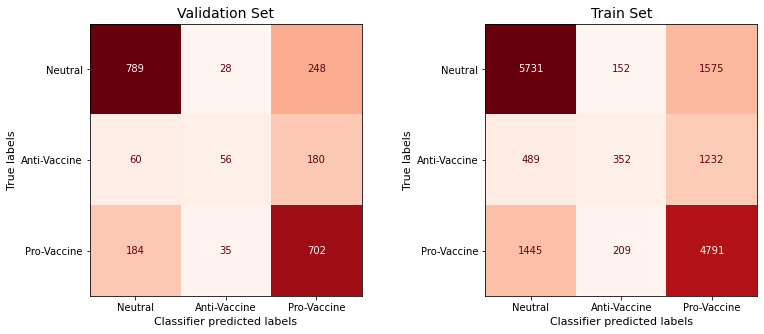

In [25]:
_, ax = plt.subplots(1, 2, figsize=(13,5))
plotConfusionMatrix(validLabels, validPredictions, 'Validation Set', CLASS_NAMES, ax[0])
plotConfusionMatrix(trainLabels, epochTrainPredictions, 'Train Set', CLASS_NAMES, ax[1])
plt.show()

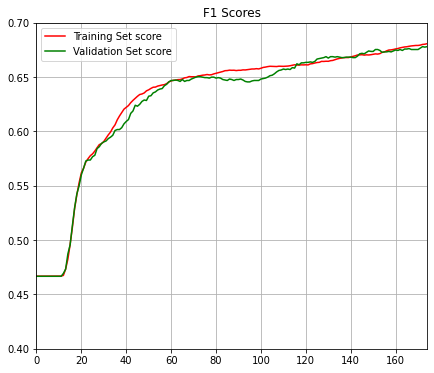

In [26]:
displayF1Curves(EPOCHS, trainF1, validF1)

In [27]:
scores = metricScores(epochTrainPredictions, validPredictions, trainLabels, validLabels)
metricStatsDF(*scores)

,F1,Precision,Recall
Train,0.6806,0.6240,0.5605
Validation,0.6779,0.6185,0.5641


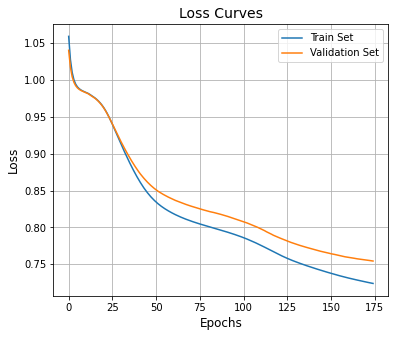

In [28]:
plotLossCurves(trainErrors, validErrors)

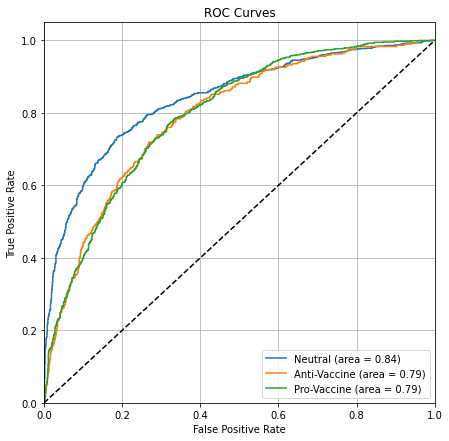

In [29]:
rocScores = createRocCurves(validLabels, validOutput)
plotRocCurves(*rocScores)